In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Библиотеки для скачивания файлов с яндекс-диска
import requests
from urllib.parse import urlencode

# Библиотеки для игнорирования предупрждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(
    font_scale=1.6,
    style="whitegrid"
        )

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Вопросы

* Предлагаем Вам ответить на следующие вопросы:
* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
* Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

# Задание 1. A/B–тестирование

## Подготовка исходных данных

In [3]:
# Ссылки на исходные данные

groups_path = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
groups_add_path = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_path = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_path = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

base_path = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [4]:
# Получение загрузочных ссылок на исходные данные

for paths in [groups_path, groups_add_path, active_studs_path, checks_path]:
    final_path = base_path + urlencode(dict(public_key=paths))
    response = requests.get(final_path)
    download_path = response.json()['href']
    
    if paths == groups_path:
        groups_path = download_path
    elif paths == groups_add_path:
        groups_add_path = download_path
    elif paths == active_studs_path:
        active_studs_path = download_path
    else:
        checks_path = download_path

In [5]:
# Импорт исходных данных

df_groups = pd.read_csv(groups_path, sep = ';')
df_groups_add = pd.read_csv(groups_add_path)
df_active_studs = pd.read_csv(active_studs_path)
df_checks = pd.read_csv(checks_path, sep = ";")

In [6]:
# Объединим исходные и добавленные данные

df_all = pd.concat([df_groups, df_groups_add])
df_all.shape[0]

74576

In [7]:
df_all.head(1)

,id,grp
0,1489,B


In [8]:
# Переименуем колонки

df_active_studs = df_active_studs.rename(columns = {'student_id': 'id'})
df_checks = df_checks.rename(columns = {'student_id': 'id'})

In [9]:
# Создадим df, отражающий принадлежность активных пользователей к той или иной группе

df_all_active_with_grp = df_all.merge(df_active_studs, on='id', how='right')
df_all_active_with_grp.shape[0]

8341

In [10]:
df_all_active_with_grp.head(1)

,id,grp
0,581585,A


In [11]:
# Создадим df, отражающий сгруппированных активных пользователей, совершивших покупку

df_all_active_checks_with_grp = df_checks.merge(df_all_active_with_grp, on = 'id', how = 'left')
df_all_active_checks_with_grp.shape[0]

541

In [12]:
df_all_active_checks_with_grp.head(1)

,id,rev,grp
0,1627,990.0,A


In [13]:
# Обнаружены пользователи, совершившие покупку, но без принадлежности к группе
# По тем или иным причинам они не попали в исходный df активных пользователей

df_all_active_checks_with_grp.isna().sum()

id       0
rev      0
grp    149
dtype: int64

In [14]:
# Выделим эту группу пользователей в отдельный df

df_nonact = df_all_active_checks_with_grp.query('grp !="A" & grp !="B"')
df_nonact.shape[0]

149

In [15]:
df_nonact.head(1)

,id,rev,grp
1,3185,690.0,NaN


In [16]:
# Сформируем исправленный df активных пользователей

df_active_studs_corr = pd.concat([df_nonact, df_active_studs]).drop(['rev','grp'], axis=1)
df_active_studs_corr.shape[0]

8490

In [17]:
# Присвоим атрибут, отражающий активных пользователей

df_active_studs_corr['act'] = 1

In [18]:
df_active_studs_corr.head(1)

,id,act
1,3185,1


In [19]:
# Создадим df, отражающий принадлежность всех пользователей к той или иной группе

df_all_with_grp = df_all.merge(df_active_studs_corr, on='id', how='left')
df_all_with_grp.act.fillna(0, inplace=True)
df_all_with_grp.shape[0]

74576

In [20]:
df_all_with_grp.head(1)

,id,grp,act
0,1489,B,0.0


In [21]:
# Создадим df, отражающий ВСЕХ сгруппированных пользователей
# В столбце rev вместо NaN вставим 0
# Отразим факты оплаты и активности юзеров в отдельных столбцах

final_df = df_all_with_grp.merge(df_checks, on = 'id', how = 'left')
final_df.rev.fillna(0, inplace=True)
final_df['act'] = final_df.act > 0
final_df['pay'] = final_df.rev > 0

In [22]:
final_df

,id,grp,act,rev,pay
0,1489,B,False,0.0,False
1,1627,A,True,990.0,True
2,1768,B,False,0.0,False
3,1783,B,False,0.0,False
4,1794,A,False,0.0,False
...,...,...,...,...,...
74571,200247820,B,False,0.0,False
74572,201032527,B,False,0.0,False
74573,201067612,B,False,0.0,False
74574,201067653,B,False,0.0,False


In [23]:
# Проверяем, всё отлично

final_df.isna().sum()

id     0
grp    0
act    0
rev    0
pay    0
dtype: int64

In [24]:
final_df.id.duplicated().sum()

0

## Проверка репрезентативности выборок

<AxesSubplot:xlabel='rev', ylabel='Count'>

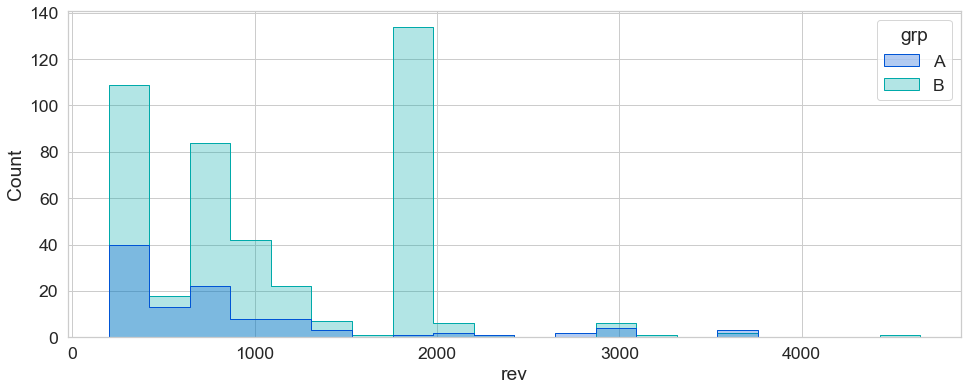

In [25]:
# В первую очередь построим графики и визульно оценим выборки
# Распределение сильно отличается от нормального
# По графику можно выявить выброс (в районе 1900)

plt.figure(figsize=(16,6))
sns.histplot(data = final_df.query('rev > 0'), 
              x = 'rev', 
              hue = 'grp', 
              palette = 'winter',
              alpha = 0.3,
              element = 'step',
              bins = 20)

<AxesSubplot:xlabel='grp', ylabel='rev'>

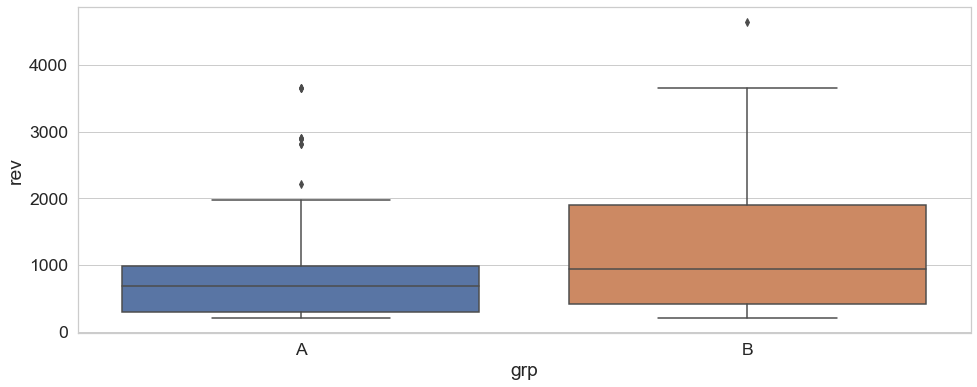

In [26]:
# На боксплотах, как и на предыдущем графике, наблюдается увеличение показателя выручки в тестовой группе

plt.figure(figsize=(16,6))
sns.boxplot(data=final_df.query('rev > 0'), x='grp', y='rev')

In [27]:
# Попробуем найти закономерность в данных, значительно выбивающихся из общей выборки

id_with_rev_1900 = final_df.query('rev > 1800 & rev < 2000').id.apply(str).to_list()
s=','.join(id_with_rev_1900)
s

'264473,287008,299195,308549,308594,330737,331312,338677,366127,368342,384731,521164,526310,536848,600890,703252,720651,759073,766755,766874,800185,806723,879402,926967,987129,1000052,1008928,1024467,1029642,1036096,1037236,1045136,1050825,1077515,1086218,1089482,1097225,1108686,1116874,1135439,1147732,1220488,1220810,1225044,1232221,1316069,1318118,1358182,1410414,1410693,1467890,1519814,1540324,1551921,1554194,1568415,1625302,1638517,1687177,1783273,1851744,1880452,1897820,1903217,2071359,2081846,2174339,2388577,2393822,2394657,2557593,2575187,2686297,2692209,2712604,2735665,2896010,2914580,2996381,3013878,3054644,3097956,3121370,3143818,3156691,3204592,3232706,3236909,3274600,3278734,3282270,3303702,3312112,3319672,3335339,3354191,3365536,3423411,3456377,3516039,3530122,3554807,3730883,3821501,3845821,3885006,3967955,3968980,3995801,4051351,4218092,4247427,4272388,4352425,4465732,4472446,4506719,4523975,4555061,4673307,4778580,4789014,4873135,4875778,4923312,5004439,5031164,5252412,

<AxesSubplot:xlabel='id'>

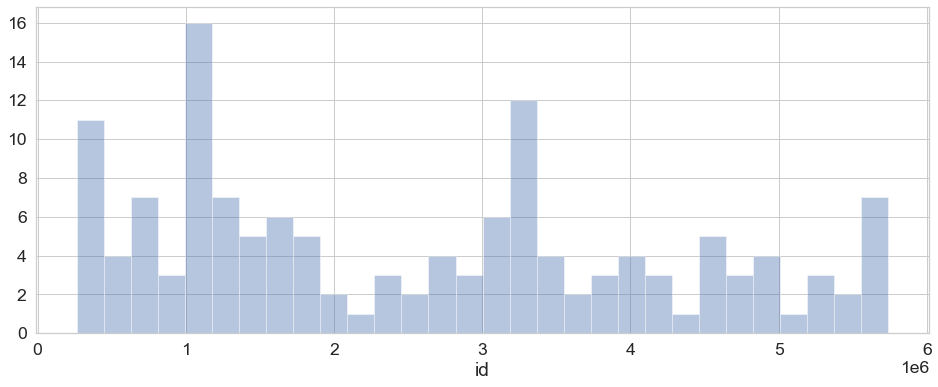

In [28]:
# Судя по поверхностному осмотру, какой-либо закономерности не выявлено

plt.figure(figsize=(16,6))
sns.distplot(final_df.query('rev > 1800 & rev < 2000').id, kde = False, bins=30)

In [29]:
# Чтобы сделать однозначный вывод, не хватает исходных данных
# Среди причин подобного поведения юзеров можно предположить, что в целевой выборке просто было предложено выгодное предложение
# стоимостью 1900
# Невозможно сделать вывод о нерепрезентативности тестовой выборки, обладая исходной информацией

final_df.query('rev > 1800 & rev < 2000').rev.value_counts()

1900.0000    97
1900.0001    36
1980.0000     4
1830.0000     1
1968.0000     1
Name: rev, dtype: int64

## Исследование необходимых метрик

In [30]:
# Главными интересующими нас метриками, опираясь на наши исходные данные, будут являться
# 1. Конверсия в покупку
# 2. Показатель активности пользователей
# 3. Средний доход на каждого пользователя (ARPU)
# 4. Средний доход на каждого покупателя (ARPPU)

# Для начала найдём общее кол-во пользователей по группам

df_sum_id = final_df.groupby('grp', as_index=False).agg({'id': 'count'}).rename(columns=({'id': 'sum_id'}))
df_sum_id

,grp,sum_id
0,A,14693
1,B,59883


In [31]:
# Найдём общее кол-во активных пользователей по группам

df_sum_act_id = final_df.query('act == True').groupby('grp', as_index=False) \
                        .agg({'id': 'count'}).rename(columns=({'id': 'sum_act_id'}))
df_sum_act_id

,grp,sum_act_id
0,A,1567
1,B,6923


In [32]:
# Найдём общее кол-во покупателей по группам

df_sum_buyer = final_df.query('rev > 0').groupby('grp', as_index=False) \
                       .agg({'id': 'count'}).rename(columns=({'id': 'sum_buyer'}))
df_sum_buyer

,grp,sum_buyer
0,A,107
1,B,434


In [33]:
# Найдём общую сумму затрат по группам

df_sum_rev = final_df.groupby('grp', as_index=False).agg({'rev': 'sum'}).round(2).rename(columns=({'rev': 'sum_rev'}))
df_sum_rev

,grp,sum_rev
0,A,92096.0
1,B,481230.0


In [34]:
# Найдём показатели среднего чека покупателей для каждой из групп (ARPPU - average revenue per paying users)

df_ARPPU = final_df.query('rev > 0').groupby('grp', as_index=False) \
                   .agg({'rev': 'mean'}).round(2).rename(columns=({'rev': 'ARPPU'}))
df_ARPPU

,grp,ARPPU
0,A,860.71
1,B,1108.82


In [35]:
# Объединим всё в один df
 
df_info = df_sum_id.merge(df_sum_act_id).merge(df_sum_buyer).merge(df_sum_rev).merge(df_ARPPU)
df_info

,grp,sum_id,sum_act_id,sum_buyer,sum_rev,ARPPU
0,A,14693,1567,107,92096.0,860.71
1,B,59883,6923,434,481230.0,1108.82


In [36]:
# Добавим конверсию в покупку активных пользователей для каждой из групп (CR - convertion rate)

df_info['CR'] = ((df_info.sum_buyer / df_info.sum_act_id)*100).round(2)

# Показатель активности юзеров (AU - active users)

df_info['AU'] = ((df_info.sum_act_id / df_info.sum_id)*100).round(2)

In [37]:
df_info

,grp,sum_id,sum_act_id,sum_buyer,sum_rev,ARPPU,CR,AU
0,A,14693,1567,107,92096.0,860.71,6.83,10.66
1,B,59883,6923,434,481230.0,1108.82,6.27,11.56


In [38]:
# Исходя из полученных данных можно сделать следующие выводы: 
# Наблюдается увеличение показателя средней выручки на одного платящего пользователя на 28.83%

ARPPU = (((df_info.ARPPU[1]-df_info.ARPPU[0])/df_info.ARPPU[0])*100).round(2)
ARPPU

28.83

In [39]:
# Показатель конверсии в тестовой группе из активного пользователя в покупателя уменьшился на 8.20%

CR = (((df_info.CR[1]-df_info.CR[0])/df_info.CR[0])*100).round(2)
CR

-8.2

In [40]:
# Показатель активности пользователей в тестовой группе также вырос на 8.44%

AU = (((df_info.AU[1]-df_info.AU[0])/df_info.AU[0])*100).round(2)
AU

8.44

## Применение статистических тестов

In [41]:
# Произведём отбор только платящих пользователей

control = final_df.query('grp == "A" and rev > 0')
test    = final_df.query('grp == "B" and rev > 0')

In [42]:
# Т.к. распределения в выборках отличаются от нормальных, для определения уровня значимости
# различий дисперсий в контрольной и тестовой группах воспользуемся критерием Левене
# Критерий Левене является альтернативой критерию Бартлетта. 
# Считается, что критерий Левене менее чувствителен к отклонениям от нормальности.

# H0: Различие дисперсии между данными группами не значимо

# H1: Различие дисперсии между данными группами значимо

# При р > 0,05 различие дисперсии между данными группами не значимо, следовательно, их можно рассматривать как гомогенные. 
# В данном примере тест Левена не дает значимого результата (p=0.118), значит дисперсии гомогенные

ss.levene(control.rev, test.rev, center='mean', proportiontocut=0.05)

LeveneResult(statistic=2.4570366586563943, pvalue=0.11758618682510892)

In [43]:
# дисперсии однородны, использование t-теста корректно. 

# p-value < 0.05, средний чек стат. значимо вырос

ss.ttest_ind(control.rev, test.rev)

Ttest_indResult(statistic=-3.0367637315797316, pvalue=0.0025070167572044644)

In [44]:
# Для оценки стат. значимых различий медианного чека применим метод бутстрапа

# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_value = min(sum(pd_boot_data[0] <= 0), sum(pd_boot_data[0] >= 0)) * 2 / len(pd_boot_data[0])    
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value_norm = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value,
            "p_value_norm": p_value_norm}

  0%|          | 0/5000 [00:00<?, ?it/s]

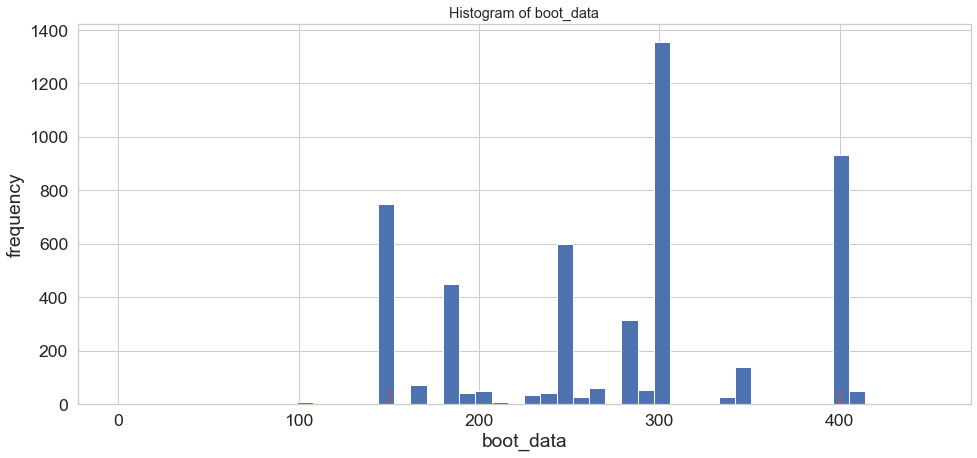

In [45]:
# Оценим стат. значимость различий медианных чеков

plt.figure(figsize=(16,7))
bs_median = get_bootstrap(test.rev, control.rev, statistic=np.median, boot_it=5000)

In [46]:
# p-value < 0.05, медианный чек стат. значимо вырос

bs_median['p_value']

0.0004

In [47]:
bs_median['ci']

,0
0.025,150.0
0.975,400.0


In [48]:
# Для определения стат. значимости снижения конверсии студента в платящего воспользуемся критерием хи-квадрат,
# т.к. имеем категориальные данные

# H0: Взаимосвязь между системой оплаты и конверсией отсутствует

# H1: Взаимосвязь между системой оплаты и конверсией есть

expected, observed, stats = pg.chi2_independence(final_df.query('act == True'), x='grp', y='pay', correction=False)

In [49]:
observed

pay,False,True
grp,,
A,1460,107
B,6489,434


In [50]:
expected

pay,False,True
grp,,
A,1467.147585,99.852415
B,6481.852415,441.147585


In [51]:
# p-value > 0.05 => нет основания отклонить нулевую гипотезу.

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.670145,1.0,0.413001,0.008884,0.129594
1,cressie-read,0.666667,0.666397,1.0,0.414311,0.008860,0.129137
2,log-likelihood,0.000000,0.659040,1.0,0.416899,0.008811,0.128241
3,freeman-tukey,-0.500000,0.653642,1.0,0.418814,0.008774,0.127583
4,mod-log-likelihood,-1.000000,0.648343,1.0,0.420706,0.008739,0.126938
5,neyman,-2.000000,0.638037,1.0,0.424423,0.008669,0.125683


In [52]:
# Для определения стат. значимости увеличения показателя активности студентов в тестовой группе 
# воспользуемся критерием хи-квадрат, т.к. имеем категориальные данные

# H0: Взаимосвязь между системой оплаты и увеличением показателя активности студентов отсутствует

# H1: Взаимосвязь между системой оплаты и увеличением показателя активности студентов есть

expected, observed, stats = pg.chi2_independence(final_df, x='grp', y='act', correction=False)

In [53]:
expected

act,False,True
grp,,
A,13020.296047,1672.703953
B,53065.703953,6817.296047


In [54]:
observed

act,False,True
grp,,
A,13126,1567
B,52960,6923


In [55]:
# p-value < 0.05 => есть основания отклонить нулевую гипотезу.

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,9.387469,1.0,0.002185,0.011220,0.865189
1,cressie-read,0.666667,9.431855,1.0,0.002132,0.011246,0.866752
2,log-likelihood,0.000000,9.522219,1.0,0.002030,0.011300,0.869885
3,freeman-tukey,-0.500000,9.591412,1.0,0.001955,0.011341,0.872239
4,mod-log-likelihood,-1.000000,9.661848,1.0,0.001881,0.011382,0.874596
5,neyman,-2.000000,9.806549,1.0,0.001739,0.011467,0.879317


# Выводы
1. Обнаружена некорректная запись исходных данных, 149 юзеров не попали в список активных клиентов, необходимо предпринять действия к устранению данной проблемы.
2. Различие дисперсии между контрольной и тестовой группами не значимо.
3. Средний чек в тестовой группе вырос на 28,83 %. T-test определил стат. значимое различие в среднем чеке. Также было выявлено стат. значимое различие медианных чеков методом бутстрапа.
4. Снижение показателя конверсии на 8.20 % не является стат. значимым.
5. Показатель активности студентов в тестовой группе стат. значимо увеличился на 8.44 % (Небольшая ремарка: нет данных по тому, за какой промежуток времени получены данные, поэтому интерпретировать эти значения оснований нет. Допустим, что эксперимент начался давно, пользователям нравятся нововведения и мы получили срез данных уже после внедрения новой фичи).
6. При незначительном уменьшении конверсии из активного пользователя в покупателя наблюдается стат. значимые приросты среднего чека и показателя активности пользователей. Исходя из этого рекомендуется внедрить новую механику оплаты на всех пользователей.

# Задание 2. SQL
## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.
### 2.1.2 Задача

Дана таблица peas:

    Название атрибута	Тип атрибута 	Смысловое значение
    st_id	            int	          ID ученика
    timest	           timestamp	    Время решения карточки
    correct	          bool	         Правильно ли решена горошина?
    subject	          text	         Дисциплина, в которой находится горошина
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [56]:
import pandahouse as ph
connection = {'database':'default',
              'host': 'http://clickhouse.beslan.pro:8080',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [57]:
query_2_1 = """
SELECT
    uniqExact(student_id)
FROM
    (
    SELECT 
          st_id as student_id,
          sum(correct) as correct_answ
    FROM
        default.peas
    WHERE toStartOfMonth(timest) = '2020-03-01'
    GROUP BY st_id
    HAVING correct_answ >= 20
    )
"""

In [58]:
ph.execute(query_2_1, connection=connection)

b'0\n'

## 2.2 Оптимизация воронки
### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

    Название атрибута	Тип атрибута 	Смысловое значение
    st_id	            int 	         ID ученика
    test_grp	         ext 	         Метка ученика в данном эксперименте
и final_project_check:

    Название атрибута	Тип атрибута 	Смысловое значение
    st_id	            int 	         ID ученика
    sale_time	        timestamp	    Время покупки
    money	            int	          Цена, по которой приобрели данный курс
    subject	          text 	        Дисциплина, на которую приобрели полный доступ
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [59]:
query_2_2 = """
SELECT ---- расчёт метрик
    test_grp,
    SUM(money) / uniqExact(st_id) as ARPU,
    sumIf(money, act=1) / countIf(DISTINCT st_id, act=1) as ARPAU,
    countIf(DISTINCT st_id, money>0) / uniqExact(st_id) as CR,
    countIf(DISTINCT st_id, act=1 and money>0) / countIf(DISTINCT st_id, act=1)  as CR_active,
    countIf(DISTINCT st_id, act=1 and M_money>0 and M_peas='1') / countIf(DISTINCT st_id, act=1 and M_peas='1') as CR_active_math  
FROM    
    (
    SELECT  ---- все студенты + активные студенты + оплата курсов, добавим столбец, 
            ---- отражающий факт оплаты, и столбец с суммой затрат каждого юзера
        st_id,
        test_grp,
        M_peas,
        V_peas,
        S_peas,
        P_peas,
        T_peas,
        act,
        M_money,
        V_money,
        S_money,
        P_money,
        T_money,
    CASE 
    WHEN checks.st_id='' THEN 0 ELSE 1
       END AS paid,
       (M_money+V_money+S_money+P_money+T_money) AS money
    FROM
        (
        SELECT  ---- все студенты + активные студенты, добавим столбец отражающий активность
            st_id,
            test_grp,
            M_peas,
            V_peas,
            S_peas,
            P_peas,
            T_peas,
        CASE 
        WHEN act_studs_with_subject_marks.st_id='' THEN 0 ELSE 1
            END AS act
        FROM
            (
            SELECT  ---- все студенты 
                *
            FROM 
                default.studs
            ) AS all_studs    
            LEFT JOIN    
            (
            SELECT  -- отбор активных студентов, за активность примем тот факт, что они есть в таблице "peas",
                    -- отобразим в одной строке для каждого юзера факт активности по каждому из предметов
                DISTINCT(st_id),
                sum(M_peas) as M_peas,
                sum(V_peas) as V_peas,
                sum(S_peas) as S_peas,
                sum(P_peas) as P_peas,
                sum(T_peas) as T_peas
            FROM
                (
                SELECT
                    st_id,
                    subject,
                    case 
                    when subject='Math' then 1 else 0
                    end as M_peas,
                    case 
                    when subject='Vizualization' then 1 else 0
                    end as V_peas,
                    case 
                    when subject='Statistics' then 1 else 0
                    end as S_peas,
                    case 
                    when subject='Python' then 1 else 0
                    end as P_peas,
                    case 
                    when subject='Theory of probability' then 1 else 0
                    end as T_peas
                FROM 
                    default.peas
                GROUP BY 
                    st_id,subject
                )
            GROUP BY 
                st_id
            ) as act_studs_with_subject_marks
            ON all_studs.st_id = act_studs_with_subject_marks.st_id
        ) as all_studs_with_act_studs_with_subject_marks
        LEFT JOIN 
        (
        SELECT  -- отбор платежей по курсам, отобразим в одной строке для каждого юзера оплату по каждому из предметов
            DISTINCT(st_id),
            sum(M_money) as M_money,
            sum(V_money) as V_money,
            sum(S_money) as S_money,
            sum(P_money) as P_money,
            sum(T_money) as T_money
        
        FROM
                (
                SELECT
                    st_id,
                    money,
                    subject,
                    case 
                    when subject='Math' then money else 0
                    end as M_money,
                    case 
                    when subject='Vizualization' then money else 0
                    end as V_money,
                    case 
                    when subject='Statistics' then money else 0
                    end as S_money,
                    case 
                    when subject='Python' then money else 0
                    end as P_money,
                    case 
                    when subject='Theory of probability' then money else 0
                    end as T_money
                FROM 
                    default.final_project_check
                GROUP BY 
                    st_id,money,subject
                order by 
                    st_id
                )
        GROUP BY 
            st_id
            ) as checks
        ON all_studs_with_act_studs_with_subject_marks.st_id = checks.st_id
    )
GROUP BY
    test_grp
"""

In [60]:
ph.execute(query_2_2, connection=connection)

b'control\t4540.983606557377\t8393.939393939394\t0.04918032786885246\t0.09090909090909091\t0.05660377358490566\npilot\t11508.474576271186\t22832.167832167834\t0.10847457627118644\t0.2097902097902098\t0.08888888888888889\n'

# Задание 3. Python
## 3.1 Задача

* Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
* Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [61]:
def updade_data(df_groups_add, df_groups=df_groups, df_active_studs=df_active_studs, df_checks=df_checks):
    
    '''
    Функция для подгрузки информации из дополнительного файла и перерасчета метрик. 
    Приниммает: 
    df_groups - df с информацией о принадлежности пользователя к контрольной или экспериментальной группе,
    df_groups_add - df с пользователями, который вам прислали после передачи данных,
    df_active_studs - df с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента,
    df_checks - df с информацией об оплатах пользователей в дни проведения эксперимента
    '''
    
    # Переименуем колонки
    df_groups_add = df_groups_add.rename(columns={df_groups_add.columns[0]: 'id', df_groups_add.columns[1]: 'grp'})
    df_active_studs = df_active_studs.rename(columns = {'student_id': 'id'})
    df_checks = df_checks.rename(columns = {'student_id': 'id'})
    
    
    # Объединим исходные и добавленные данные
    df_all = pd.concat([df_groups, df_groups_add])

    # Создадим df, отражающий принадлежность активных пользователей к той или иной группе
    df_all_active_with_grp = df_all.merge(df_active_studs, on='id', how='right')
    
    # Создадим df, отражающий сгруппированных активных пользователей, совершивших покупку
    df_all_active_checks_with_grp = df_checks.merge(df_all_active_with_grp, on = 'id', how = 'left')
    
    # Обнаружение пользователей, совершивших покупку, но без принадлежности к группе
    if df_all_active_checks_with_grp.isna().sum()[2] != 0:
        print(f'Обнаружено {df_all_active_checks_with_grp.isna().sum()[2]} пользователей, \
не отмеченных активными, необходимо проверить исходные данные')
    
    # Выделим эту группу пользователей в отдельный df
    df_nonact = df_all_active_checks_with_grp.query('grp !="A" & grp !="B"')
    
    # Сформируем исправленный df активных пользователей, с присвоением атрибута активности
    df_active_studs_corr = pd.concat([df_nonact, df_active_studs]).drop(['rev','grp'], axis=1)
    df_active_studs_corr['act'] = 1
    
    # Создадим df, отражающий принадлежность всех пользователей к той или иной группе
    df_all_with_grp = df_all.merge(df_active_studs_corr, on='id', how='left')
    df_all_with_grp.act.fillna(0, inplace=True)
    
    # Создадим df, отражающий ВСЕХ сгруппированных пользователей
    # В столбце rev вместо NaN вставим 0
    # Отразим факты оплаты и активности юзеров в отдельных столбцах
    final_df = df_all_with_grp.merge(df_checks, on = 'id', how = 'left')
    final_df.rev.fillna(0, inplace=True)
    final_df['act'] = final_df.act > 0
    final_df['pay'] = final_df.rev > 0
        
    # Проводим проверку   
    if final_df.id.duplicated().sum() != 0:
        print('Имеются дубликаты в группах. Требуется проверка')
    
    # Для начала найдём общее кол-во пользователей по группам
    df_sum_id = final_df.groupby('grp', as_index=False).agg({'id': 'count'}).rename(columns=({'id': 'sum_id'}))
    
    # Найдём общее кол-во активных пользователей по группам
    df_sum_act_id = final_df.query('act == True').groupby('grp', as_index=False) \
                        .agg({'id': 'count'}).rename(columns=({'id': 'sum_act_id'}))
    
    # Найдём общее кол-во покупателей по группам
    df_sum_buyer = final_df.query('rev > 0').groupby('grp', as_index=False) \
                       .agg({'id': 'count'}).rename(columns=({'id': 'sum_buyer'}))
    
    # Найдём общую сумму затрат по группам
    df_sum_rev = final_df.groupby('grp', as_index=False).agg({'rev': 'sum'}).round(2).rename(columns=({'rev': 'sum_rev'}))
    
    # Найдём показатели среднего чека покупателей для каждой из групп (ARPPU - average revenue per paying users)
    df_ARPPU = final_df.query('rev > 0').groupby('grp', as_index=False) \
                   .agg({'rev': 'mean'}).round(2).rename(columns=({'rev': 'ARPPU'}))
    
    # Объединим всё в один df
    df_info = df_sum_id.merge(df_sum_act_id).merge(df_sum_buyer).merge(df_sum_rev).merge(df_ARPPU)
    
    # Добавим конверсию в покупку активных пользователей для каждой из групп (CR - convertion rate)
    df_info['CR'] = ((df_info.sum_buyer / df_info.sum_act_id)*100).round(2)

    # Показатель активности юзеров (AU - active users)
    df_info['AU'] = ((df_info.sum_act_id / df_info.sum_id)*100).round(2)
    
    return df_info

In [62]:
updade_data(df_groups_add)

Обнаружено 149 пользователей, не отмеченных активными, необходимо проверить исходные данные


,grp,sum_id,sum_act_id,sum_buyer,sum_rev,ARPPU,CR,AU
0,A,14693,1567,107,92096.0,860.71,6.83,10.66
1,B,59883,6923,434,481230.0,1108.82,6.27,11.56


In [63]:
final_df

,id,grp,act,rev,pay
0,1489,B,False,0.0,False
1,1627,A,True,990.0,True
2,1768,B,False,0.0,False
3,1783,B,False,0.0,False
4,1794,A,False,0.0,False
...,...,...,...,...,...
74571,200247820,B,False,0.0,False
74572,201032527,B,False,0.0,False
74573,201067612,B,False,0.0,False
74574,201067653,B,False,0.0,False


In [64]:
df_info

,grp,sum_id,sum_act_id,sum_buyer,sum_rev,ARPPU,CR,AU
0,A,14693,1567,107,92096.0,860.71,6.83,10.66
1,B,59883,6923,434,481230.0,1108.82,6.27,11.56


In [65]:
def vizualization(df_info, final_df):
    
    '''
    Функция для визуализации. Принимает:
    df_info - таблица с метриками ['grp', 'sum_id', 'sum_act_id', 'sum_buyer', 'sum_rev', 'ARPPU', 'CR', 'AU'],
    final_df - результирующая таблица с данными['id', 'grp' , 'act' , 'rev', 'pay']
    '''
    
    sns.set(
    font_scale=1.6,
    style="whitegrid"
        )
    
    control_rev = final_df.query('grp == "A" & rev > 0').rev
    test_rev    = final_df.query('grp == "B" & rev > 0').rev
    
    # Графики распределения сумм покупок по группам
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    sns.histplot(control_rev, ax=axes[0], color='r')
    sns.histplot(test_rev, ax=axes[1], color='b')
    axes[0].set(title='Revenue group A', xlabel='Expenses')
    axes[1].set(title='Revenue group B', xlabel='Expenses')
    
    # Боксплот покупок и показатели среднего чека по группам
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    sns.boxplot(data=final_df[final_df.rev > 0], x='grp', y='rev', ax=axes[0], palette = ['r', 'b'])
    sns.barplot(x='grp', y='ARPPU', data=df_info, ax=axes[1], palette = ['r', 'b'])
    axes[0].set(title='Revenue by groups', ylabel='', xlabel='Groups')
    axes[1].set(title='ARPPU', ylabel='', xlabel='Groups')
    
    
    # Показатели конверсии в покупателя и активности по группам
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    sns.barplot(x='grp', y='CR', data=df_info, ax=axes[0], palette = ['r', 'b'])
    sns.barplot(x='grp', y='AU', data=df_info, ax=axes[1], palette = ['r', 'b'])
    axes[0].set(title='CR', ylabel='', xlabel='Groups')    
    axes[1].set(title='AU', ylabel='', xlabel='Groups')
    
    
    
    plt.show()

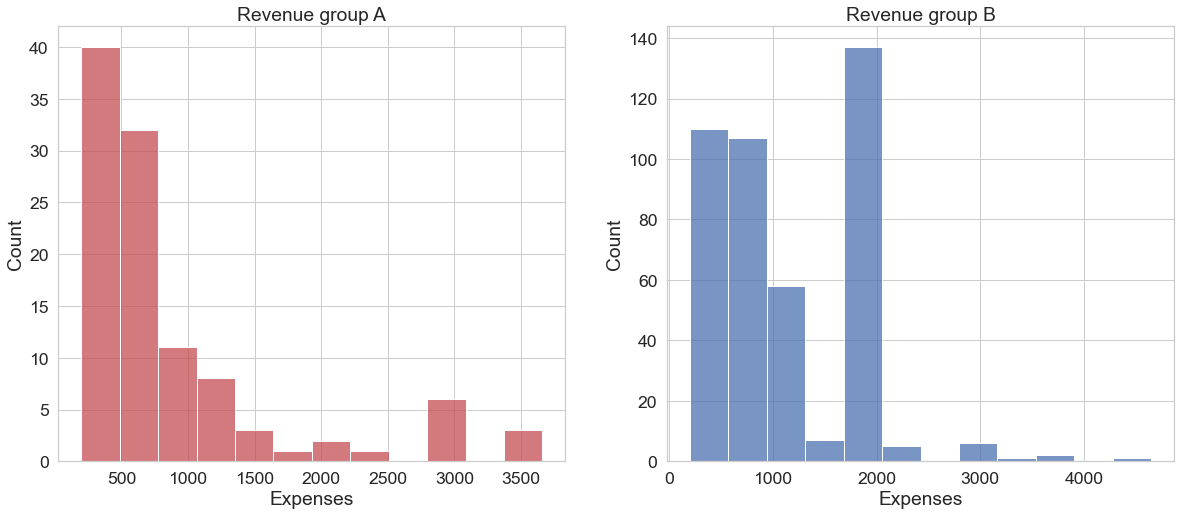

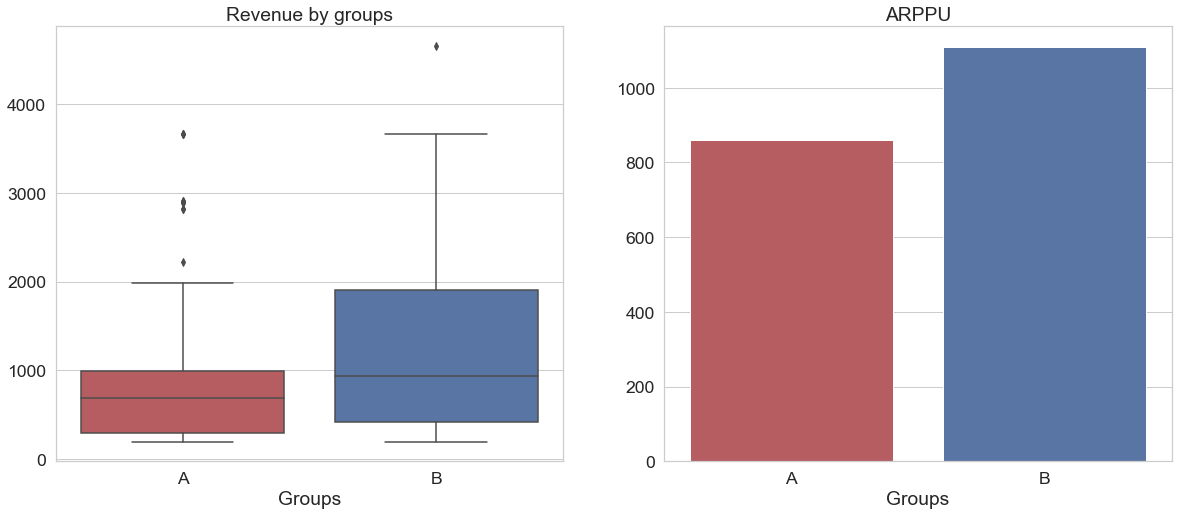

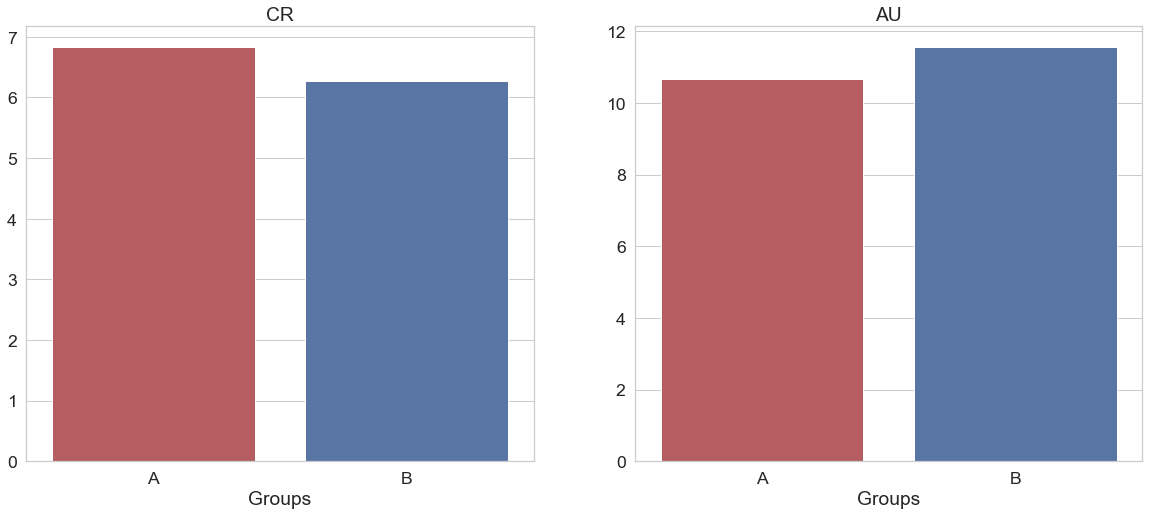

In [66]:
vizualization(df_info, final_df)